<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Cross validation and train-test splits

---

### Learning Objectives

### Core
- Describe train-test split and cross-validation
- Explain why we want to use these validation techniques and how they differ
- Split data into test and training sets using both train-test split and cross validation 
- Apply both techniques to score a model

### Target
- Use sklearn to split into training and test sets
- Use sklearn for cross validation

### Stretch
- Describe why it is useful to have an additional hold-out test set
- Explain when it might be a good idea to shuffle the dataset before cross validation

### Lesson Guide
- [Overfitting and underfitting](#overfitting-underfitting)
- [Train-test split](#train-test-split)
- [K-Fold cross-validation](#cross-val-k-fold)
- [Train-test-split demonstration](#demo)
    - [Plot a heatmap](#heatmap)
    - [Select a single predictor for SLR](#single-predictor)
    - [Split data into training and testing](#sklearn-tts)
    - [Fit a linear regression on the training data](#fit-on-train)
- [K-Fold cross-validation demonstration](#cv-demo)
- [Review: negative $R^2$ values](#neg-r2)
- [Hold-out sets](#hold-out)
- [Conclusion](#conclusion)
- [Additional resources](#additional-resources)
- [Summary of cross validation procedure](#summary)
- [Code for reference](#code)

<a id='overfitting-underfitting'></a>

## Overfitting and underfitting

---

![](assets/regression_overfitting.jpg)

Source: Victor Lavrenko on [youtube](https://youtu.be/dBLZg-RqoLg)

**What is wrong with the first model?**
- The underfit model falls short of capturing the complexity of the "true model" of the data.

**What is wrong with the third model?**
- The overfit model is too complex and is modeling random noise in the data.

**The middle model is a good compromise.**
- It approximates the complexity of the true model and does not model random noise in our sample as true relationships.

<a name="train-test-split"></a>

## Train-test split and model validation

---

So far we've focused on fitting the best model to our data. But is this the best model for our sample data or the best model overall? How do we know?

In practice, we need to validate our model's ability to generalize to new data. One very popuplar method for performing model validation is by splitting our data into subsets: data that we *train* our model on, and data that we *test* our model on.

The most basic type of "hold-out" validation is called **train-test split**. We split our data into two pieces:

> **"Training set":** the subset of the data that we fit our model on.

> **"Testing set":** the subset of the data that we evaluate the quality of our predictions on.


**Test/train split benefits:**
- Testing data can be a proxy for "future" data; for prediction-oriented models it is critical to make sure a model performing well on current data will likely perform well on future data.
- Can help diagnose and avoid overfitting via model tuning.
- Improve the quality of our predictions.

Using train-test split it can happen that the train and test sets are not really representative of the whole data distribution. For example, if you are not careful it is easy to take a non-random split. 

Suppose we have salary data on technical professionals that is composed 80% of data from London and 20% elsewhere and is sorted by county. If we split our data into 80% training data and 20% testing data we might inadvertantly select all the London data to train and all the non-London data to test. In this case we have still overfit our data set because we did not sufficiently randomise the data. A method to reduce this kind of bias is to use cross validation.

<a id='cross-val-k-fold'></a>

## K-Fold cross-validation

---

K-Fold cross-validation takes the idea of a single train-test split and expands this to *multiple tests* across different train-test splits of your data.

For example, if you determine your training set will contain 2/3 of the data and your testing set will contain the other 1/3, you could have 3 different 2/3 splits where the test set in each is a different set of observations. We have:
- 3 (K=3) training sets
- 3 (K=3) corresponding test sets

**K-Fold cross-validation builds K models, one for each train-test pair, and evaluates those models on each respective test-set.**

### K-Fold cross-validation visually

<img src="https://snag.gy/o1lLcw.jpg?convert_to_webp=true" width="500"a>

---

Cross-validation helps us to understand how a model parameterization may perform in a variety of cases. The K-Fold cross-validation procedure can be described in pseudocode:

```
set k
create k groups of rows in data

for group i in k row groups:
    test data is data[group i]
    train data is data[all groups not i]
    
    fit model on train data
    
    score model on test data
    
evaluate mean of k model scores
evaluate variance of k model scores
```

Odd case #1:
> **When K=2**: This is equivalent to doing ***two*** mirror image 50-50 train-test splits.

Odd case #2:
> **When K=number of rows**: This is known as "leave one out cross-validation" or LOOCV. A model is built on all but one row and tested on the single held-out observation.

<a id='demo'></a>

## Train-test split with sklearn demonstration

---

Let's use sklearn to load everyone's favorite data set: the boston housing data.

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
# Load the Boston Housing dataset
boston = datasets.load_boston()
print(boston.keys())
#
df = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

# Take a look at the data again
df.head(2)

dict_keys(['data', 'target', 'feature_names', 'DESCR'])


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14


<a id='heatmap'></a>

### Plot a heatmap of the correlation matrix

Heatmaps are a great way to visually examine the correlation structure of your predictors. 

> Keep in mind that pearson correlations between non-dummy-coded categorical variables and other variables are invalid!


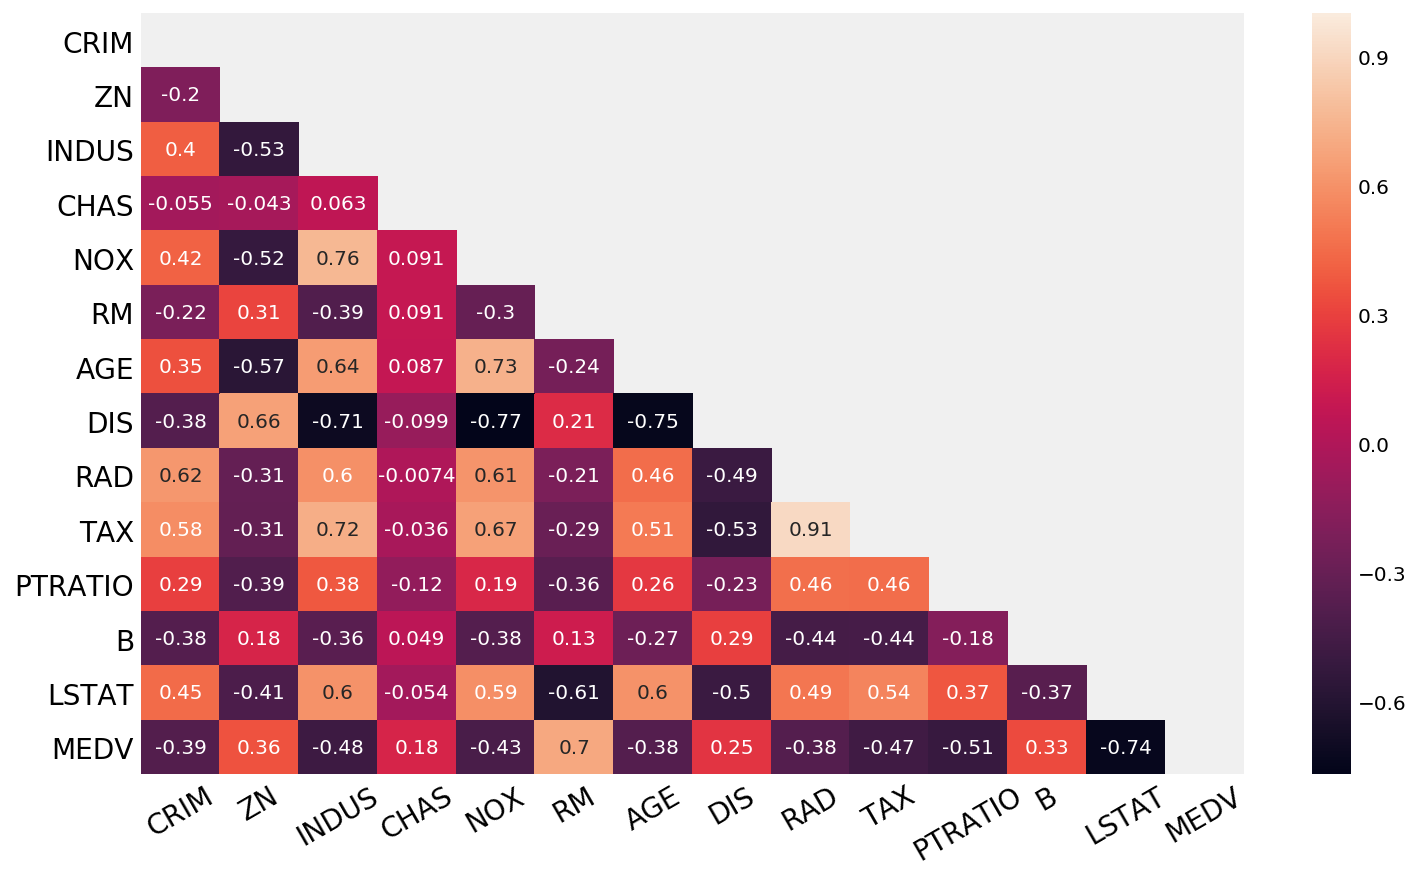

In [3]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(11, 7))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()


df_with_target = df.copy()
df_with_target['MEDV'] = y
correlation_heat_map(df_with_target)

<a id='single-predictor'></a>

### Select a single predictor for a SLR

The variable `AGE` appears to have a minor linear relationship with the target variable, `MEDV`.

Let's select just `AGE` out of the data as a single column design matrix.

In [4]:
X = df[['AGE']]
X.head(3)

,AGE
0,65.2
1,78.9
2,61.1


#### It is good practice to plot the variable against the target to confirm the relationship visually.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


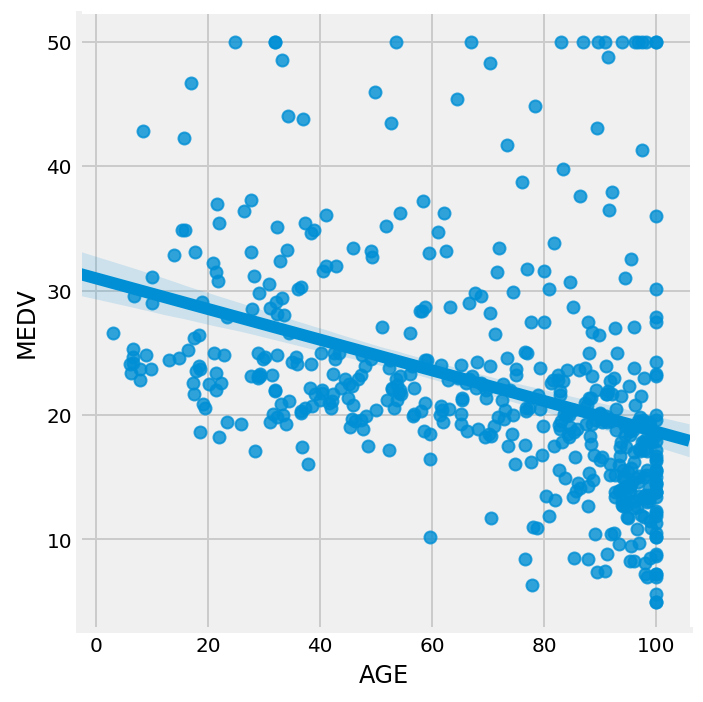

In [5]:
sns.lmplot('AGE', 'MEDV', df_with_target)
plt.show()

<a id='sklearn-tts'></a>

### Sklearn's `train_test_split` function

Train test split using sklearn is easy. Load the `train_test_split` function:

```python
from sklearn.model_selection import train_test_split
```

**Arguments**:
- `*arrays`: Any number of arrays/matrices to split up into training and testing (they should be the same length).
- `test_size`: an integer for exact size of the test subset or a float for a percentage
- `train_size`: alternatively you can specify the training size
- `stratify`: supply a vector to stratify the split (more important in classification tasks)

**Perform a 50-50 split of our `X` and `y`:**

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

In [29]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(253, 1) (253,)
(253, 1) (253,)


Note that we could always split the data up manually. Here's an [example](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py) of manually splitting the data.

<a id='fit-on-train'></a>

### Fit a linear regression on the training set

Using the training `X` and training `y`, we can fit a linear regression with sklearn's `LinearRegression`.

In [33]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

<a id='score-on-test'></a>

### Calculate the $R^2$ score on the training data

After we have constructed our model on the training set, we can evaluate how well our model performs on this training data set.

In [34]:
print(slr.score(X_train, y_train))

0.1234880164292902


### Calculate the $R^2$ score on the test data

After we have constructed our model on the training set, we can evaluate how well our model performs on data it did not have any exposure to.

In [38]:
from sklearn.metrics import r2_score

print(slr.score(X_test, y_test) ,r2_score(y_test,slr.predict(X_test)))

0.16024827004266562 0.16024827004266562


#### Is the performance different? Does that meet your expectations?

<a id='cv-demo'></a>

## K-Fold cross-validation demonstration

---


Now let's try out k-fold cross-validation. Again scikit-learn provides useful functions to do the heavy lifting. 

The function `cross_val_score` returns the $R^2$ for each test set. 

Alternatively, the function `cross_val_predict` returns the predicted values for each data point when it's in the testing slice.


In [39]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 5-fold cross validation
scores = cross_val_score(slr, X, y, cv=5)
print("Cross-validated scores:", scores)
print("Mean of Ccoss-validated scores:", scores.mean())

Cross-validated scores: [ 0.04495477  0.05074154 -0.69817202 -0.06274528 -1.21254137]
Mean of Ccoss-validated scores: -0.3755524742970227


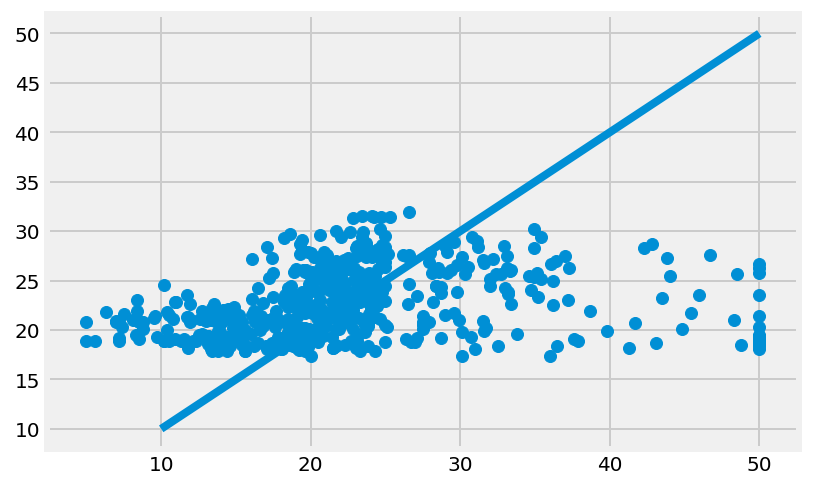

In [40]:
# Make cross validated predictions on the test sets
predictions = cross_val_predict(slr, X, y, cv=5)

point_1 = [10, 50]
plt.plot(point_1, point_1)
plt.scatter(y, predictions)
plt.show()

#### We could calculate the $R^2$ for the predicted values, but this gives a different (usually larger) result. Conventionally one rather looks at the mean of the scores from the cross validation steps as above.

In [41]:
print("Cross-Predicted R2:", metrics.r2_score(y, predictions))

Cross-Predicted R2: 0.035849643276377186


#### We can plot the predicted values $\hat{y}$ versus the predictor variable $X$.

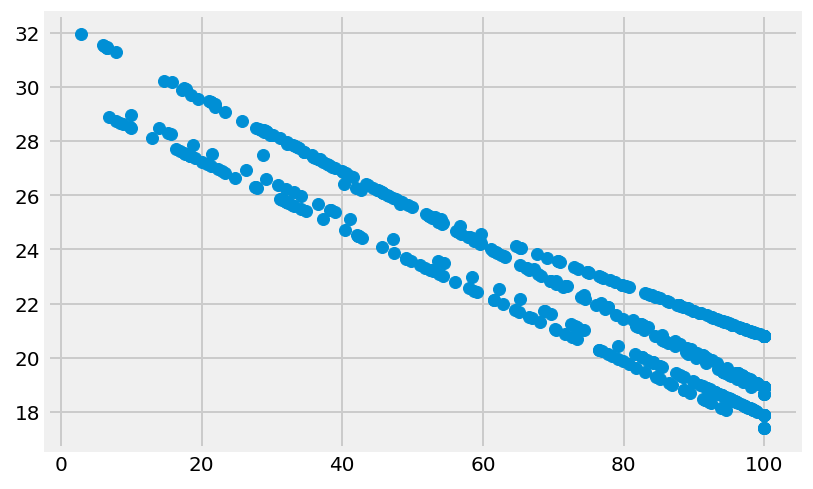

In [42]:
plt.scatter(X.values, predictions)
plt.show()

In [43]:
predictions.shape

(506,)

<a id='neg-r2'></a>
## Review: negative $R^2$ values

---

What does it mean to have a negative $R^2$?

A negative $R^2$ only makes sense (and can only be found) when we are evaluating the $R^2$ score on data that the model was not fit on. If $R^2$ is evaluated for a model using the training data, *the minimum $R^2$ must be zero.* 

However, on a test set the $R^2$ **can** be negative. This means that the model performs so poorly on the testing set that you would have been better off just using the mean of the target from the training set as an estimate!

## K-fold cross validation with and without shuffling

#### Sometimes it can be useful to make the method used for cross validation explicit. The one used above is k-fold cross validation. 

In [44]:
from sklearn.model_selection import KFold

In [45]:
scores = cross_val_score(slr, X, y, cv=KFold(n_splits=5))
print("Cross-validated scores:", scores)
print("Mean cross-validated scores:", scores.mean())

Cross-validated scores: [ 0.04495477  0.05074154 -0.69817202 -0.06274528 -1.21254137]
Mean cross-validated scores: -0.3755524742970227


Using this explicit form can be useful for the following reason.

The default k-fold split happens in the order in which the data is stored. 
If the data contains some order, this can be problematic. Using `KFold` allows you to shuffle the data before doing the cross-validation.

- `n_splits` indicates the number of k-folds used
- `shuffle=True` will shuffle the data before splitting into k-folds
- `random_state` set to a specific value will always lead to the same result

In [46]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores_shuffled = cross_val_score(slr, X, y, cv=kf)
print("Cross-validated scores:", scores_shuffled)
print("Mean cross-validated scores:", scores_shuffled.mean())

Cross-validated scores: [0.04578214 0.05554249 0.28794777 0.12649095 0.15360479]
Mean cross-validated scores: 0.1338736275949795


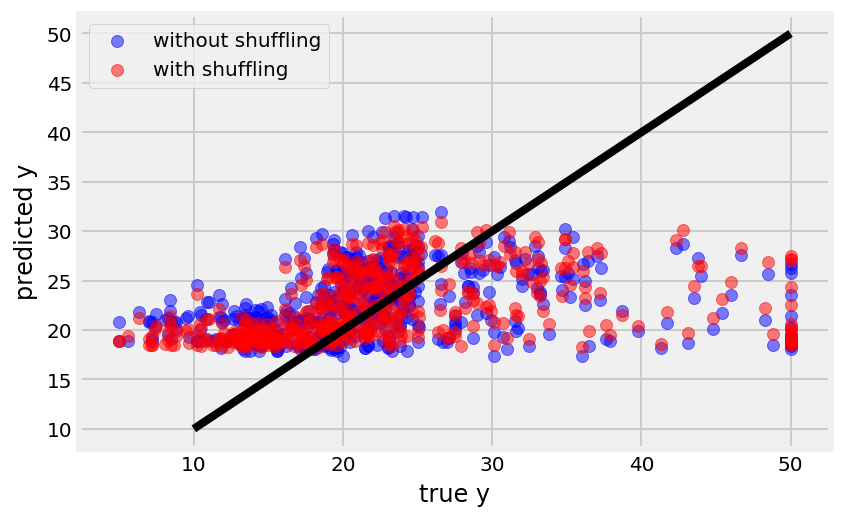

In [47]:
# Make cross validated predictions on the test sets
predictions_shuffled = cross_val_predict(slr, X, y, cv=kf)

point_1 = [10, 50]
plt.plot(point_1, point_1, 'k')
plt.scatter(y, predictions, c='b', alpha=0.5, label='without shuffling')
plt.scatter(y, predictions_shuffled, c='r', alpha=0.5, label='with shuffling')
plt.xlabel('true y')
plt.ylabel('predicted y')
plt.legend()
plt.show()

<a id='hold-out'></a>

## Hold-out sets

---

Hold-out sets are a version of train-test split. The concept of having a hold-out set is:
1. **Split the data into a large train and small test set. This small test set will be the "hold-out" set.**
2. **For a set of different model parameterizations:**
    1. **Set up the model.**
    2. **Cross-validate the current model on the training data.**
    3. **Save the model performance.**
3. **Select the model that performed best using cross-validation on the training data.**
4. **Perform a final test of that model on the original "hold-out" test set.**

> **Note:** The "hold-out" method is more conservative, but also requires that you have more data. With smaller datasets it can be infeasable.

The graphic below explains the hold-out method visually.

![](./assets/Train-Test-Split-CV.png)

<a id='conclusion'></a>

## Conclusion

- Split data into test and training sets
- Performed cross validation scoring
- Made cross validation predictions

**Benefits of validation:**

- Test the model
- Avoid overfitting
- Assess how well a model generalises to an independet dataset



<a id='additional-resources'></a>

## Additional Resources

---

- [Cross-validation Example](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py)
- [Plotting Cross-Validated Predictions](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html)
- Examine this [academic paper](http://frostiebek.free.fr/docs/Machine%20Learning/validation-1.pdf) on the underpinnings of the holdout method, LOOVC, and kfolds
- The sklearn [documentation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) on cross validation is strong
- This [Stanford lesson](https://www.youtube.com/watch?v=_2ij6eaaSl0) on cross validation
- This [blog post](http://www.win-vector.com/blog/2015/01/random-testtrain-split-is-not-always-enough/) on why TTS is not always enough
- StackExchange [discussion](http://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio) on approximate TTS, validation set sizes

<a id='summary'></a>
## Summary of cross validation procedure

1. Divide data into training, validation, testing sets
2. Select architecture (model type) and training parameters (k)
3. Train the model using the training set
4. Evaluate the model using the validation set
5. Repeat 2-4 selecting different architectures (models) and tuning parameters
6. Select the best model
7. Assess the model with the final testing set

<a id='code'></a>
## Code for reference

#### Import some data

In [48]:
from matplotlib import pyplot as plt
% matplotlib inline
# Make the plots bigger
plt.rcParams['figure.figsize'] = (6, 6)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold

In [49]:
# Load the diabetes dataset
columns = "age sex bmi map tc ldl hdl tch ltg glu".split()
diabetes = datasets.load_diabetes()
df = pd.DataFrame(diabetes.data, columns=columns)
y = diabetes.target
# Take a look at the data again
print(df.head())
print(df.shape)

        age       sex       bmi       map        tc       ldl       hdl  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

        tch       ltg       glu  
0 -0.002592  0.019908 -0.017646  
1 -0.039493 -0.068330 -0.092204  
2 -0.002592  0.002864 -0.025930  
3  0.034309  0.022692 -0.009362  
4 -0.002592 -0.031991 -0.046641  
(442, 10)


#### Train_test_split 

The test_size keyword argument indicates the proportion of the data that should be held over for testing.

In [50]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


# fit a model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print("Test Score:", model.score(X_test, y_test))

(353, 10) (353,)
(89, 10) (89,)
Test Score: 0.4524665463041172


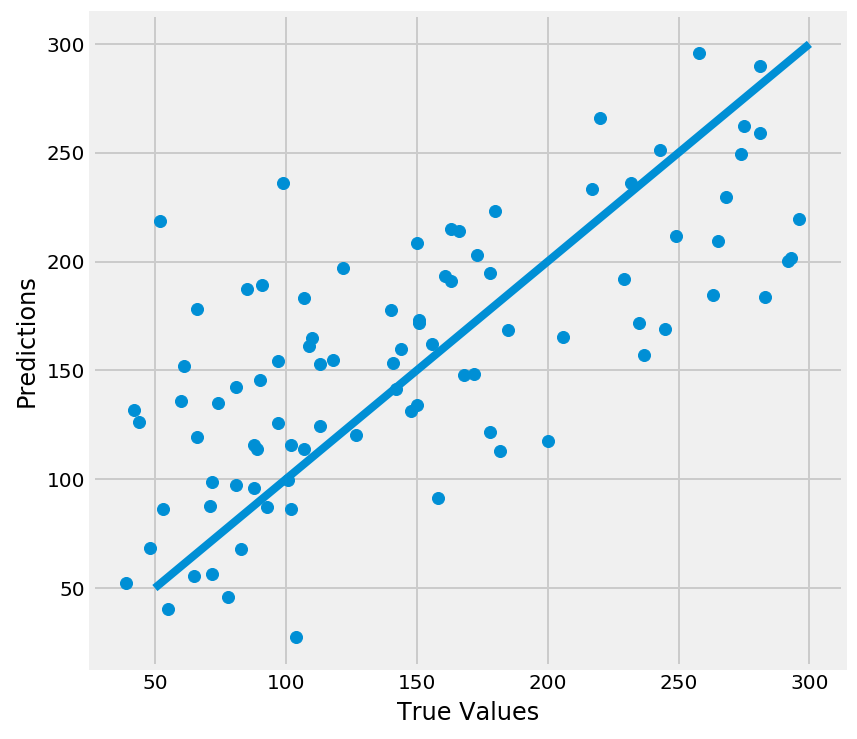

In [51]:
# The line / model
point_1 = [50, 300]
plt.scatter(y_test, predictions)
plt.plot(point_1, point_1)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

#### K-fold cross-validation

In [52]:
# Perform 6-fold cross validation
scores = cross_val_score(model, df, y, cv=6)
print("Cross-validated scores:", scores)
print("Mean cross-validated score:", scores.mean())
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=6)

Cross-validated scores: [0.4554861  0.46138572 0.40094084 0.55220736 0.43942775 0.56923406]
Mean cross-validated score: 0.4797803047530258


In [53]:
# The same with shuffling
kf = KFold(n_splits=6, shuffle=True, random_state=1)
scores_shuffled = cross_val_score(model, df, y, cv=kf)
print("Cross-validated scores:", scores_shuffled)
print("Mean cross-validated score:", scores_shuffled.mean())
predictions_shuffled = cross_val_predict(model, df, y, cv=kf)

Cross-validated scores: [0.41806134 0.43132456 0.43901536 0.45437643 0.52670604 0.55341115]
Mean cross-validated score: 0.4704824801358529


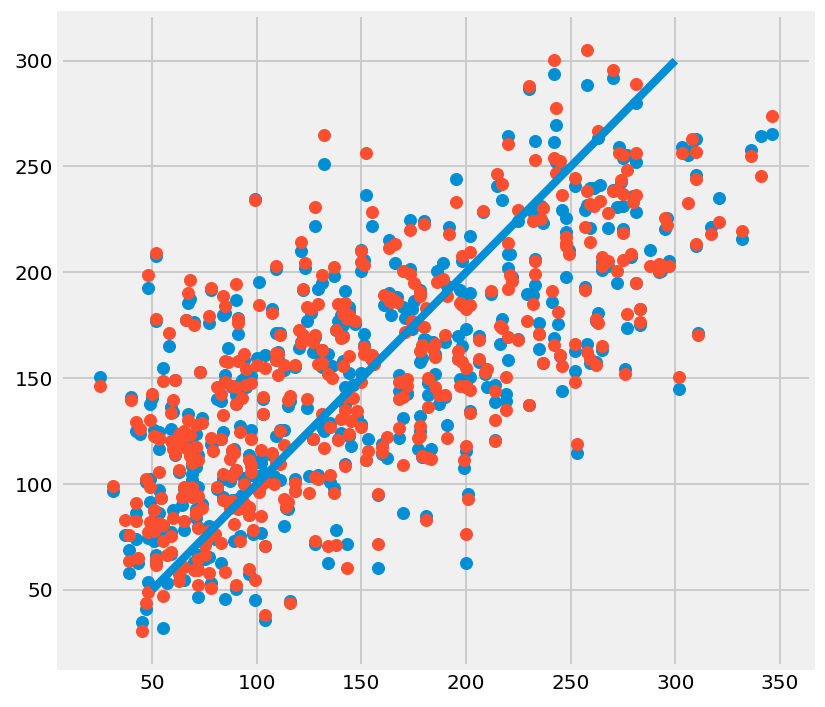

In [54]:
plt.scatter(y, predictions)
plt.scatter(y, predictions_shuffled)
plt.plot(point_1, point_1)
plt.show()